In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/scratch/network/yc6206/representation-engineering')
from transformers import AutoTokenizer, pipeline, AutoModelForCausalLM
import torch
from datasets import load_from_disk, load_dataset
import copy

from transformers import AutoTokenizer, pipeline, AutoModelForCausalLM
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import numpy as np
import pynvml
import pickle

from repe import repe_pipeline_registry
repe_pipeline_registry()

device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    pynvml.nvmlInit()
    handle = pynvml.nvmlDeviceGetHandleByIndex(0)
    print(pynvml.nvmlDeviceGetName(handle))

from sklearn.decomposition import DictionaryLearning
from sklearn.decomposition import SparseCoder
import matplotlib.pyplot as plt

/scratch/network/yc6206/miniconda3/envs/repe/lib/python3.11/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [79]:
user_tag = "USER:"
assistant_tag = "ASSISTANT:"

# Uncomment for first time loading the dataset
# ds = load_dataset('tatsu-lab/alpaca', cache_dir='../../storage/cache')
# ds.save_to_disk("../../storage/cache/alpaca_filtered/")

ds = load_from_disk('../../storage/cache/alpaca_filtered/')
instructions = ds['train']['instruction']
outputs = ds['train']['output']

control_template = "{type}"
template = "{user_tag} {instruction} {type} {assistant_tag} {response}"
# Not sure why they set this offset
cutoff_offset = 5

def get_augmented_ds(instructions, responses, num_examples, user_tag, assistant_tag, aug_prompt, control_template, max_res_len):
    
    ds = []
    for p, s in zip(instructions, responses):
        # Replaced \n since it resulted in nontrivial peak
        # s_tokens = tokenizer.tokenize(s)
        s_tokens = tokenizer.tokenize(s.replace("\n", ""))
        for cutoff in range(1, min(max_res_len, len(s_tokens)) - cutoff_offset):
            s_truncated = tokenizer.convert_tokens_to_string(s_tokens[:cutoff])
            ds.append(template.format(
                user_tag=user_tag,
                assistant_tag=assistant_tag,
                instruction=p,
                type=control_template.format(type=aug_prompt),
                response=s_truncated
            ))
            if len(ds) >= num_examples:
                break
        if len(ds) >= num_examples:
            break
    return ds

def get_contrastive_ds(instructions, responses, num_examples, user_tag, assistant_tag, pos_type, neg_type, control_template, max_res_len):
    
    pos_s = get_augmented_ds(instructions, responses, num_examples, user_tag, assistant_tag, pos_type, control_template, max_res_len)
    neg_s = get_augmented_ds(instructions, responses, num_examples, user_tag, assistant_tag, neg_type, control_template, max_res_len)
    assert len(pos_s) == len(neg_s)
    
    contrastive_ds = []
    for i in range(len(pos_s)):
        contrastive_ds.append(pos_s[i])
        contrastive_ds.append(neg_s[i])
    return contrastive_ds

def get_rep_directions(aug_prompt, num_examples=2048, max_res_len=64, batch_size=32, rep_token=-1, verbose=False):
    augmented_ds = get_augmented_ds(
        instructions,
        outputs,
        num_examples,
        user_tag,
        assistant_tag,
        aug_prompt,
        control_template,
        max_res_len
    )

    hidden_layers = list(range(-1, -model.config.num_hidden_layers, -1))
    rep_reading_pipeline = pipeline("rep-reading", model=model, tokenizer=tokenizer)
    if verbose:
        print(f"Computing Rep Activation {aug_prompt}")

    hidden_reps = rep_reading_pipeline._batched_string_to_hiddens(
        train_inputs=augmented_ds,
        rep_token=rep_token,
        hidden_layers=hidden_layers,
        batch_size=batch_size,
        which_hidden_states=None
    )
    
    for k in hidden_reps:
        hidden_reps[k] = torch.Tensor(hidden_reps[k]).to(device)

    return hidden_reps, augmented_ds

def get_rep_reader(pos_type, neg_type, num_examples=2048, max_res_len=64, rep_token=-1, verbose=False):
    contrastive_ds = get_contrastive_ds(
        instructions,
        outputs,
        num_examples,
        user_tag,
        assistant_tag,
        pos_type,
        neg_type,
        control_template,
        max_res_len
    )
    contrastive_ds_train = contrastive_ds

    hidden_layers = list(range(-1, -model.config.num_hidden_layers, -1))
    n_difference = 1
    direction_method = 'pca'
    rep_reading_pipeline = pipeline("rep-reading", model=model, tokenizer=tokenizer)
    if verbose:
        print(f"Computing Rep {pos_type} - {neg_type}")

    rep_reader = rep_reading_pipeline.get_directions(
        contrastive_ds_train,
        rep_token=rep_token, 
        hidden_layers=hidden_layers, 
        n_difference=n_difference, 
        train_labels=None, 
        direction_method=direction_method,
        batch_size=32,
    )
    return rep_reader.directions, contrastive_ds_train

In [84]:
with open('/scratch/network/yc6206/representation-engineering/examples/extraction/reading_vecs_sc.pickle', 'rb') as f:
    reading_vectors = pickle.load(f)

In [81]:
emotions = []
with open ('list_of_emotions.txt', 'r') as f:
    emotions = f.readlines()
    emotions = [emotion.strip('\n') for emotion in emotions]
stimulis = {}
for emotion in emotions:
    stimulis[emotion] = 'Respond with a tone of {}'.format(emotion.lower())
stimulis[''] = ''

stimuli_pairs_gen = {}
for s in stimulis:
    if s != '':
        stimuli_pairs_gen[s] = [s, '']

stimuli_pairs = {k: [stimulis[stimuli_pairs_gen[k][0]], stimulis[stimuli_pairs_gen[k][1]]] for k in stimuli_pairs_gen}

In [ ]:
reading_vectors = {}
for k in (pbar := tqdm(stimuli_pairs)):
    pbar.set_postfix_str(k)
    if not k in reading_vectors:
        rep_reader, _ = get_rep_reader(stimuli_pairs[k][0], stimuli_pairs[k][1], num_examples=256)
        reading_vectors[k] = copy.deepcopy(rep_reader)

with open('/scratch/network/yc6206/representation-engineering/examples/extraction/reading_vecs_sc.pickle', 'wb') as f:
    pickle.dump(reading_vectors, f)

In [ ]:
with open('/scratch/network/yc6206/representation-engineering/examples/extraction/sparse_coding.pickle', 'rb') as f:
    sparse_coding_dict = pickle.load(f)

# sparse_coding_dict = {}

for n_components in (pbar := tqdm(range(5, 105, 5))):
    sparse_coding_dict[n_components] = {}
    for layer in reading_vectors['Happiness']:
        X = []
        sparse_coding_dict[n_components][layer] = {}
        for emotion in emotions:
            X.append(reading_vectors[emotion][layer])
        X = np.concatenate(X)
        dict_learner = DictionaryLearning(n_components=n_components, transform_algorithm='lasso_lars', transform_alpha=0.1, random_state=42, n_jobs=-1, transform_n_nonzero_coefs=2)
        sc_dict = dict_learner.fit(X)
        sparse_coding_dict[n_components][layer]['dictionary'] = sc_dict.components_
        for emotion in emotions:
            sparse_coding_dict[n_components][layer][emotion] = sc_dict.transform(reading_vectors[emotion][layer])

    with open('/scratch/network/yc6206/representation-engineering/examples/extraction/sparse_coding.pickle', 'wb') as f:
        pickle.dump(sparse_coding_dict, f)

### analysis

In [2]:
with open('/scratch/network/yc6206/representation-engineering/examples/extraction/sparse_coding1.pickle', 'rb') as f:
   sparse_coding_dict = pickle.load(f)


with open('/scratch/network/yc6206/representation-engineering/examples/extraction/reading_vecs_sc.pickle', 'rb') as f:
    reading_vectors = pickle.load(f)

In [3]:
emotions = []
with open ('list_of_emotions.txt', 'r') as f:
    emotions = f.readlines()
    emotions = [emotion.strip('\n') for emotion in emotions]

##### reconstruction errors

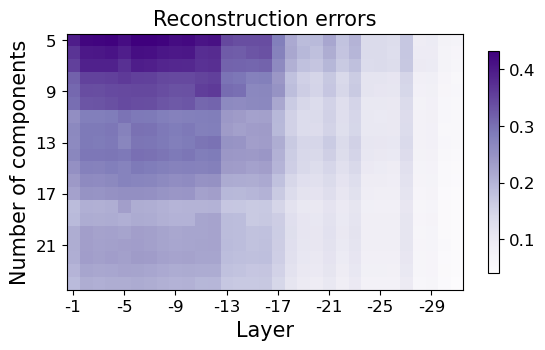

In [6]:
n_component_range = len(sparse_coding_dict)
layer_range = len(sparse_coding_dict[5])
recon_errs = np.zeros((n_component_range, layer_range))
for i, n_component in enumerate(sparse_coding_dict):
    for j, layer in enumerate(reading_vectors['Happiness']):
        recon_err = []
        for emotion in emotions:
            X = reading_vectors[emotion][layer]
            X_hat = sparse_coding_dict[n_component][layer][emotion] @ sparse_coding_dict[n_component][layer]['dictionary']
            recon_err.append(np.mean(np.sum((X_hat - X) ** 2, axis=1) / np.sum(X ** 2, axis=1)))
        recon_errs[i, j] = np.mean(recon_err)
        
s = 4
plt.imshow(recon_errs, cmap='Purples')
plt.xticks(list(range(len(list(reading_vectors['Happiness'].keys()))))[::s], list(reading_vectors['Happiness'].keys())[::s], fontsize=12)
plt.yticks(list(range(len(list(sparse_coding_dict.keys()))))[::s], list(sparse_coding_dict.keys())[::s], fontsize=12)
plt.xlabel('Layer', fontsize=15)
plt.ylabel('Number of components', fontsize=15)
cbar = plt.colorbar(shrink=0.6)
cbar.ax.tick_params(labelsize=12)
plt.savefig('recon_err.pdf', bbox_inches='tight')
plt.title('Reconstruction errors', fontsize=15)
plt.show()

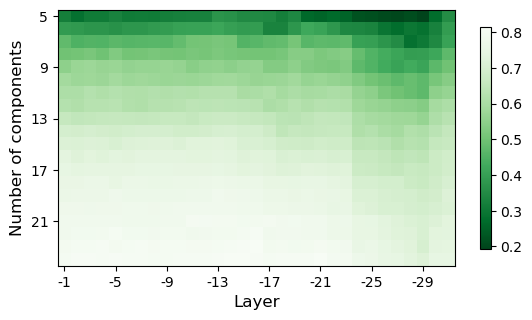

In [93]:
n_component_range = len(sparse_coding_dict)
layer_range = len(sparse_coding_dict[5])
sparsities = np.zeros((n_component_range, layer_range))
for i, n_component in enumerate(sparse_coding_dict):
    for j, layer in enumerate(reading_vectors['Happiness']):
        sparsity = []
        for emotion in emotions:
            sparsity.append(np.mean(sparse_coding_dict[n_component][layer][emotion] == 0))
        sparsities[i, j] = np.mean(sparsity)

plt.imshow(sparsities, cmap='Greens_r')
plt.xticks(list(range(len(list(reading_vectors['Happiness'].keys()))))[::s], list(reading_vectors['Happiness'].keys())[::s])
plt.yticks(list(range(len(list(sparse_coding_dict.keys()))))[::s], list(sparse_coding_dict.keys())[::s])
plt.xlabel('Layer', fontsize=12)
plt.ylabel('Number of components', fontsize=12)
plt.colorbar(shrink=0.6)
plt.savefig('sparsity.pdf', bbox_inches='tight')
plt.show()
        

In [144]:
def get_decomposition(n_component, layer):
    basic_emotions = {}
    unknown_emotions = []
    for emotion in emotions:
        x = sparse_coding_dict[n_component][layer][emotion]
        if np.count_nonzero(x) == 1:
            n = np.where(x[0] != 0)[0][0]
            tmp = basic_emotions.get(n, [])
            tmp.append((emotion, x[0][n]))
            basic_emotions[n] = tmp
    for i in range(n_component):
        if not i in basic_emotions:
            unknown_emotions.append(i)
            basic_emotions[i] = [('emotion{}'.format(i), 1.0)]
    return basic_emotions, unknown_emotions

for n_component in sparse_coding_dict:
    for layer in sparse_coding_dict[5]:
        basic_emotions, unknown_emotions = get_decomposition(n_component, layer)
        # print(basic_emotions)      
        # print("unknown emotions:", unknown_emotions)
        if len(unknown_emotions) == 0:
            print("For {} components, layer {}".format(n_component, layer), basic_emotions)

{1: [('Fear', 0.8999518752098083)], 14: [('Surprise', 0.8999524712562561)], 13: [('Joy', 0.8392059206962585), ('Excitement', 0.8475155830383301), ('Elation', 0.9001127481460571)], 19: [('Boredom', 0.899958074092865)], 6: [('Despair', 0.8999501466751099)], 7: [('Curiosity', 0.8999999165534973)], 5: [('Indignation', 0.8999506235122681)], 15: [('Resentment', 0.8999506235122681)], 9: [('Panic', 0.8999583721160889)], 4: [('Terrified', 0.899949848651886)], 11: [('Melancholy', 0.8999505043029785)], 12: [('Respect', 0.8999600410461426)], 18: [('Indifference', 0.8999501466751099)], 8: [('Shock', 0.89994877576828)], 2: [('Confident', 0.9001572132110596)], 10: [('Arrogance', 0.8999932408332825)], 3: [('Humiliated', 0.8999755382537842)], 0: [('Annoyed', 0.8999497294425964)]}
unknown emotions: [16, 17]


In [142]:
n_component = 19
layer = -1
basic_emotions, unknown_emotions = get_decomposition(n_component, layer)
for emotion in emotions:
    x = sparse_coding_dict[n_component][layer][emotion]
    if np.count_nonzero(x) != 1:
        decomp = ''
        nonzero_coeffs = np.where(x[0] != 0)[0]
        # print(emotion, nonzero_coeffs, x)
        decomp += '{} = $'.format(emotion)
        for index in nonzero_coeffs:
            # print(type(x[0][index]), type(basic_emotions[index][0][1]))
            decomp += '{:.2f} * \\text{{{}}} + '.format(x[0][index]/basic_emotions[index][0][1], basic_emotions[index][0][0])
        print(decomp[:-3]+'$')

Happiness = 0.00 * Curiosity + 0.97 * Joy 
Sadness = 0.13 * Despair + 0.83 * Melancholy 
Anger = 0.13 * Annoyed + 0.63 * Indignation + 0.08 * Panic + 0.13 * Resentment 
Disgust = 0.07 * Fear + 0.06 * Humiliated + 0.06 * Terrified + 0.25 * Indignation + 0.43 * Resentment + 0.04 * emotion17 
Love = 0.07 * Confident + 0.22 * Melancholy + 0.12 * Respect + 0.51 * Joy 
Anxiety = 0.17 * Fear + 0.01 * Humiliated + 0.08 * Terrified + 0.09 * Curiosity + 0.42 * Panic + 0.08 * Melancholy + 0.00 * Respect + 0.03 * emotion16 + 0.12 * emotion17 
Contentment = 0.34 * Confident + 0.11 * Curiosity + 0.14 * Melancholy + 0.18 * Respect + 0.24 * Joy 
Hope = 0.26 * Confident + 0.02 * Curiosity + 0.10 * Melancholy + 0.11 * Respect + 0.46 * Joy 
Pride = 0.18 * Confident + 0.03 * Indignation + 0.11 * Arrogance + 0.23 * Respect + 0.43 * Joy 
Shame = 0.57 * Humiliated + 0.26 * Indignation + 0.17 * Despair + 0.01 * Melancholy 
Guilt = 0.00 * Confident + 0.57 * Humiliated + 0.04 * Despair + 0.03 * Curiosity + 0.11